In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Some Plot setting
plt.close('all')
plt.rcParams['font.family']='serif'
plt.rcParams['font.serif']='Time New Roman'
plt.rcParams['font.size']=12
#plt.rcParams['figure.dpi']=100 ! useful, when generating the plot 


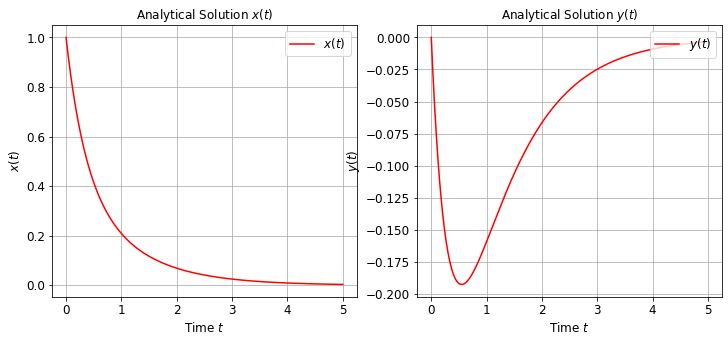

In [14]:
# Define the time domain 
t=np.linspace(0,5,500)

#Define the analytical solution for x(t) and y(t)
x_analytical =0.5*np.exp(-t)+0.5*np.exp(-3*t)
y_analytical=-0.5*np.exp(-t)+0.5*np.exp(-3*t)

# Set up the plot with two solution side by side
plt.figure(figsize=(12,5))

#plot x(t)
plt.subplot(1, 2, 1)
plt.plot(t, x_analytical, label=r'$x(t)$', color='red')
plt.title(r'Analytical Solution $x(t)$', fontsize=12)
plt.xlabel(r'Time $t$', fontsize=12)
plt.ylabel(r'$x(t)$', fontsize=12)
plt.grid(True)
plt.legend( fontsize=12, loc="upper right")

#plot x(t)
plt.subplot(1, 2, 2)
plt.plot(t, y_analytical, label=r'$y(t)$', color='red')
plt.title(r'Analytical Solution $y(t)$', fontsize=12)
plt.xlabel(r'Time $t$', fontsize=12)
plt.ylabel(r'$y(t)$', fontsize=12)
plt.grid(True)
plt.legend( fontsize=12, loc="upper right")

# Physics Informed Neural Networks Apprach for Inverse Problems

In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )
        # Learnable coefficients 
        self.coeff_c1 = nn.Parameter(
            10.0 * torch.rand(1, dtype=torch.float32, device=device),
            requires_grad=True
        )
        self.coeff_c2 = nn.Parameter(
            10.0 * torch.rand(1, dtype=torch.float32, device=device),
            requires_grad=True
        )

    def forward(self, t):
        # ensure input is of shape (batch_size, 1)
        t = t.view(-1, 1)
        return self.net(t)

# Example of instantiation
pinn = PINN().to(device)

        
        
        

In [12]:
def loss_fn(model, t, t_data, x_data, y_data):
    # make sure t is set to require gradients
    t = t.clone().detach().requires_grad_(True)

    # ---- PDE‐residual loss ----
    pred = model(t)
    x = pred[:, 0:1]
    y = pred[:, 1:2]

    dx_dt = torch.autograd.grad(
        x, t, grad_outputs=torch.ones_like(x), create_graph=True
    )[0]
    dy_dt = torch.autograd.grad(
        y, t, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]

    res_x = dx_dt + model.coeff_c1 * x + y
    res_y = dy_dt + model.coeff_c2 * x + 2 * y
    pde_loss = torch.mean(res_x**2) + torch.mean(res_y**2)

    # ---- Initial‐condition loss (assuming x(0)=1, y(0)=0) ----
    init_loss = (x[0] - 1.0)**2 + (y[0] - 0.0)**2

    # ---- Data‐fitting loss ----
    # (t_data need not require grad)
    pred_data = model(t_data)
    x_pred_data = pred_data[:, 0:1]
    y_pred_data = pred_data[:, 1:2]
    data_loss = (
        torch.mean((x_pred_data - x_data)**2)
        + torch.mean((y_pred_data - y_data)**2)
    )

    # ---- Total loss ----
    loss = 2 * pde_loss + init_loss + data_loss
    return loss

    
    
    
    
    

In [16]:
def train(model, optimizer, t, t_data, x_data, y_data, epochs, print_every=500):
    # ensure everything’s on the right device
    t      = t.to(device)
    t_data = t_data.to(device)
    x_data = x_data.to(device)
    y_data = y_data.to(device)

    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()

        loss = loss_fn(model, t, t_data, x_data, y_data)
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            print(
                f"Epoch {epoch:5d} | "
                f"Loss: {loss.item():.6e} | "
                f"C1: {model.coeff_c1.item():.4f} | "
                f"C2: {model.coeff_c2.item():.4f}"
            )


In [18]:
# Create the model and optimizer
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



Learned C1 = 1.9954
Learned C2 = 0.9934
t=0.00 | PINN x=0.9965, y=-0.0010  |  analytic x=1.0000, y=0.0000
t=1.26 | PINN x=0.1495, y=-0.1308  |  analytic x=0.1528, y=-0.1301
t=2.53 | PINN x=0.0372, y=-0.0402  |  analytic x=0.0403, y=-0.0398
t=3.79 | PINN x=0.0079, y=-0.0119  |  analytic x=0.0113, y=-0.0113
t=5.00 | PINN x=0.0004, y=-0.0042  |  analytic x=0.0034, y=-0.0034
Epoch   500 | Loss: 7.254912e-03 | C1: 1.9995 | C2: 0.9980
Epoch  1000 | Loss: 3.619353e-05 | C1: 1.9985 | C2: 0.9960
Epoch  1500 | Loss: 1.254446e-05 | C1: 1.9985 | C2: 0.9961
Epoch  2000 | Loss: 9.589427e-06 | C1: 1.9998 | C2: 0.9983
Epoch  2500 | Loss: 1.270186e-05 | C1: 1.9991 | C2: 0.9977
Epoch  3000 | Loss: 1.432683e-02 | C1: 1.9996 | C2: 0.9982
Epoch  3500 | Loss: 9.839095e-06 | C1: 1.9985 | C2: 0.9971
Epoch  4000 | Loss: 9.139439e-06 | C1: 1.9988 | C2: 0.9974
Epoch  4500 | Loss: 8.686053e-03 | C1: 1.9998 | C2: 0.9983
Epoch  5000 | Loss: 1.328361e-05 | C1: 1.9931 | C2: 0.9920


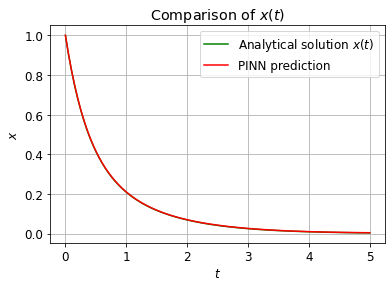

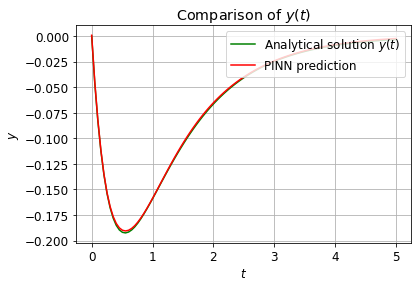

In [27]:


# Define collocation points for PDE residual
t_train = torch.linspace(0, 5, 200, device=device).view(-1, 1)

# 1) Print out the learned coefficients:
print(f"Learned C1 = {model.coeff_c1.item():.4f}")
print(f"Learned C2 = {model.coeff_c2.item():.4f}")

# 2) Print a few sample predictions alongside the analytical values:
for idx in [0, 25, 50, 75, 99]:
    tt = t_np[idx, 0]
    xp, yp = x_pred[idx, 0], y_pred[idx, 0]
    xa, ya = x_true[idx, 0], y_true[idx, 0]
    print(f"t={tt:.2f} | PINN x={xp:.4f}, y={yp:.4f}  |  analytic x={xa:.4f}, y={ya:.4f}")


# Train the model
train(model, optimizer, t_train, t_data_tensor, x_data_tensor, y_data_tensor, epochs=5000)

# Evaluate on test set
t_test = torch.linspace(0, 5, 100, device=device).view(-1, 1)
with torch.no_grad():
    pred_test = model(t_test)

x_pred = pred_test[:, 0:1].cpu().numpy()
y_pred = pred_test[:, 1:2].cpu().numpy()
t_np = t_test.cpu().numpy()

# Analytical solutions
x_true = 0.5 * np.exp(-t_np) + 0.5 * np.exp(-3 * t_np)
y_true = -0.5 * np.exp(-t_np) + 0.5 * np.exp(-3 * t_np)

# Plot x(t)
plt.figure()
plt.plot(t_np, x_true, label='Analytical solution $x(t)$',color='green')
plt.plot(t_np, x_pred, label='PINN prediction', color='red')
plt.title('Comparison of $x(t)$')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.grid(True)
plt.legend( fontsize=12, loc="upper right")

# Plot y(t)
plt.figure()
plt.plot(t_np, y_true, label='Analytical solution $y(t)$',color='green')
plt.plot(t_np, y_pred, label='PINN prediction',color='red')
plt.title('Comparison of $y(t)$')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.grid(True)
plt.legend( fontsize=12, loc="upper right")

plt.show()
